In [ ]:
%cd aws-deepcomposer-samples-master/ar-cnn
!mkdir checkpoints outputs
!ls

/content/aws-deepcomposer-samples-master/ar-cnn
augmentation.py		 inference_parameters.json  readme.md
AutoRegressiveCNN.ipynb  inference.py		    requirements.txt
checkpoints		 LICENSE.txt		    sample_inputs
constants.py		 losses.py		    sample_outputs
data_generator.py	 model.py		    utils
images			 outputs


In [ ]:

!pip install -r requirements.txt

     |████████████████████████████████| 18.5MB 78.3MB/s 
     |████████████████████████████████| 5.6MB 14.4MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
  Created wheel for pypianoroll: filename=pypianoroll-0.5.3-cp36-none-any.whl size=23827 sha256=bf0c1d40f33ead8e45f1f00190e8ef5692bf57bef761e6279bb9aae5a0185cf4
  Stored in directory: /root/.cache/pip/wheels/29/c8/c0/7b240ab723c2f96b03391796bdf278de513eabf1dfb989c07f
  Created wheel for music21: filename=music21-5.7.2-cp36-none-any.whl size=22024602 sha256=d2994891a78001f544d333baa5ccbb4da4c4102ef3dc72899c993bf53929ce54
  Stored in directory: /root/.cache/pip/wheels/6e/d0/05/1ef3daa9ae295073d807e468fcd820641965086424f1c633e3
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591953 sha256=94fd8687acb204826da8e3161450f97b2e92eaf9a334cad30b5e5e5ef50aaff2
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pypianoroll m

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import glob
import json
import numpy as np
import keras
from enum import Enum
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from random import randrange
import random
import math
import pypianoroll
from utils.midi_utils import play_midi, plot_pianoroll, get_music_metrics, process_pianoroll, process_midi
from constants import Constants
from augmentation import AddAndRemoveAPercentageOfNotes
from data_generator import PianoRollGenerator
from utils.generate_training_plots import GenerateTrainingPlots
from inference import Inference
from model import OptimizerType
from model import ArCnnModel

Using TensorFlow backend.


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3432448/45929032 bytes (7.5%)7725056/45929032 bytes (16.8%)11976704/45929032 bytes (26.1%)16220160/45929032 bytes (35.3%)20488192/45929032 bytes (44.6%)24666112/45929032 bytes (53.7%)28901376/45929032 bytes (62.9%)33030144/45929032 bytes (71.9%)37273600/45929032 bytes (81.2%)41549824/45929032 bytes (90.5%)45768704/45929032 bytes (99.7%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [ ]:
!wget http://www-etud.iro.umontreal.ca/~boulanni/JSB%20Chorales.zip

--2020-08-13 04:26:41--  http://www-etud.iro.umontreal.ca/~boulanni/JSB%20Chorales.zip
Resolving www-etud.iro.umontreal.ca (www-etud.iro.umontreal.ca)... 132.204.26.158
Connecting to www-etud.iro.umontreal.ca (www-etud.iro.umontreal.ca)|132.204.26.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 215242 (210K) [application/zip]
Saving to: ‘JSB Chorales.zip’

JSB Chorales.zip    100%[===================>] 210.20K   571KB/s    in 0.4s    

2020-08-13 04:26:41 (571 KB/s) - ‘JSB Chorales.zip’ saved [215242/215242]



In [ ]:
!unzip JSB\ Chorales.zip

Archive:  JSB Chorales.zip
   creating: JSB Chorales/
   creating: JSB Chorales/test/
  inflating: JSB Chorales/test/323.mid  
  inflating: JSB Chorales/test/280.mid  
  inflating: JSB Chorales/test/62.mid  
  inflating: JSB Chorales/test/129.mid  
  inflating: JSB Chorales/test/230.mid  
  inflating: JSB Chorales/test/341.mid  
  inflating: JSB Chorales/test/91.mid  
  inflating: JSB Chorales/test/166.mid  
  inflating: JSB Chorales/test/380.mid  
  inflating: JSB Chorales/test/60.mid  
  inflating: JSB Chorales/test/151.mid  
  inflating: JSB Chorales/test/102.mid  
  inflating: JSB Chorales/test/152.mid  
  inflating: JSB Chorales/test/132.mid  
  inflating: JSB Chorales/test/255.mid  
  inflating: JSB Chorales/test/225.mid  
  inflating: JSB Chorales/test/72.mid  
  inflating: JSB Chorales/test/231.mid  
  inflating: JSB Chorales/test/376.mid  
  inflating: JSB Chorales/test/68.mid  
  inflating: JSB Chorales/test/319.mid  
  inflating: JSB Chorales/test/216.mid  
  inflating: JSB 

In [ ]:
data_dir = 'JSB Chorales/**/*.mid'
midi_files = glob.glob(data_dir)

random_midi = randrange(len(midi_files))
play_midi(midi_files[random_midi])

In [ ]:
def generate_samples(midi_files, bars, beats_per_bar, beat_resolution, bars_shifted_per_sample):
    """
    dataset_files: All files in the dataset
    return: piano roll samples sized to X bars
    """
    timesteps_per_nbars = bars * beats_per_bar * beat_resolution
    time_steps_shifted_per_sample = bars_shifted_per_sample * beats_per_bar * beat_resolution
    samples = []
    for midi_file in midi_files:
        pianoroll = process_midi(midi_file, beat_resolution) 
        samples.extend(process_pianoroll(pianoroll, time_steps_shifted_per_sample, timesteps_per_nbars))
    return samples

In [ ]:
dataset_samples = generate_samples(midi_files, Constants.bars, Constants.beats_per_bar,Constants.beat_resolution, Constants.bars_shifted_per_sample)

random.shuffle(dataset_samples);

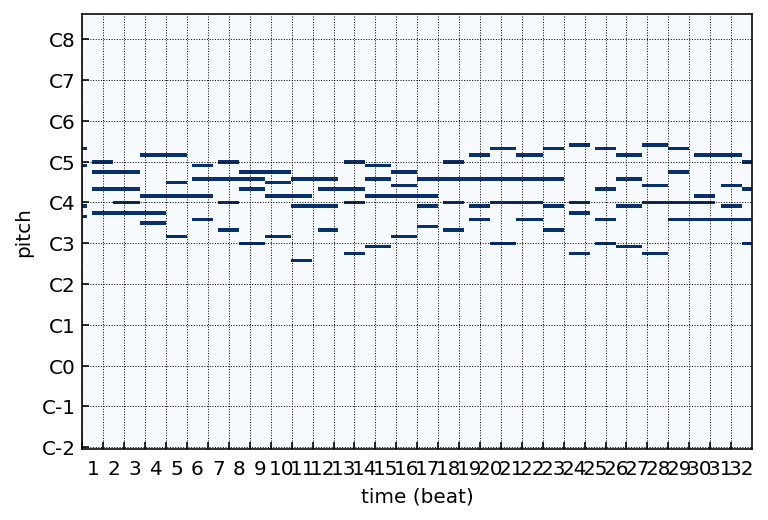

In [ ]:
random_pianoroll = dataset_samples[randrange(len(dataset_samples))]
plot_pianoroll(pianoroll = random_pianoroll,
               beat_resolution = 4)

In [ ]:
sampling_lower_bound_remove = 0 
sampling_upper_bound_remove = 100
sampling_lower_bound_add = 1
sampling_upper_bound_add = 1.5

In [ ]:
class Loss():
    @staticmethod 
    def built_in_softmax_kl_loss(target, output):
        '''
        Custom Loss Function
        :param target: ground truth values
        :param output: predicted values
        :return kullback_leibler_divergence loss
        '''
        target = K.flatten(target)
        output = K.flatten(output)
        target = target / K.sum(target)
        output = K.softmax(output)
        return keras.losses.kullback_leibler_divergence(target, output)

In [ ]:
dataset_size = len(dataset_samples)
dataset_split = math.floor(dataset_size * Constants.training_validation_split) 

training_samples = dataset_samples[0:dataset_split]
print("training samples length: {}".format(len(training_samples)))
validation_samples = dataset_samples[dataset_split + 1:dataset_size]
print("validation samples length: {}".format(len(validation_samples)))

training samples length: 881
validation samples length: 97


In [ ]:
input_dim = (Constants.bars * Constants.beats_per_bar * Constants.beat_resolution, 
             Constants.number_of_pitches, 
             Constants.number_of_channels)
num_filters = 32
growth_factor = 2
num_layers = 5
dropout_rate_encoder = [0, 0.5, 0.5, 0.5, 0.5]
dropout_rate_decoder = [0.5, 0.5, 0.5, 0.5, 0]
batch_norm_encoder = [True, True, True, True, False]
batch_norm_decoder = [True, True, True, True, False]
pre_trained = False
learning_rate = 0.001
optimizer_enum = OptimizerType.ADAM
batch_size = 128
epochs =  200

In [ ]:
steps_per_epoch = int(
    len(training_samples) * Constants.samples_per_ground_truth_data_item / int(batch_size))

print("The Total Number Of Steps Per Epoch Are: "+ str(steps_per_epoch))

n_timesteps = Constants.bars * Constants.beat_resolution * Constants.beats_per_bar

The Total Number Of Steps Per Epoch Are: 55


In [ ]:
training_data_generator = PianoRollGenerator(sample_list=training_samples,
                                             sampling_lower_bound_remove = sampling_lower_bound_remove,
                                             sampling_upper_bound_remove = sampling_upper_bound_remove,
                                             sampling_lower_bound_add = sampling_lower_bound_add,
                                             sampling_upper_bound_add = sampling_upper_bound_add,
                                             batch_size = batch_size,
                                             bars = Constants.bars,
                                             samples_per_data_item = Constants.samples_per_ground_truth_data_item,
                                             beat_resolution = Constants.beat_resolution,
                                             beats_per_bar = Constants.beats_per_bar,
                                             number_of_pitches = Constants.number_of_pitches,
                                             number_of_channels = Constants.number_of_channels)

In [ ]:
validation_data_generator = PianoRollGenerator(sample_list = validation_samples,
                                               sampling_lower_bound_remove = sampling_lower_bound_remove,
                                               sampling_upper_bound_remove = sampling_upper_bound_remove,
                                               sampling_lower_bound_add = sampling_lower_bound_add,
                                               sampling_upper_bound_add = sampling_upper_bound_add,
                                               batch_size = batch_size, 
                                               bars = Constants.bars,
                                               samples_per_data_item = Constants.samples_per_ground_truth_data_item,
                                               beat_resolution = Constants.beat_resolution,
                                               beats_per_bar = Constants.beats_per_bar, 
                                               number_of_pitches = Constants.number_of_pitches,
                                               number_of_channels = Constants.number_of_channels)

In [ ]:
plot_losses = GenerateTrainingPlots()
checkpoint_filepath =  'checkpoints/-best-model-epoch:{epoch:04d}.hdf5'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks_list = [plot_losses, model_checkpoint_callback]

In [ ]:
MusicModel = ArCnnModel(input_dim = input_dim,
                        num_filters = num_filters,
                        growth_factor = growth_factor,
                        num_layers = num_layers,
                        dropout_rate_encoder = dropout_rate_encoder,
                        dropout_rate_decoder = dropout_rate_decoder,
                        batch_norm_encoder = batch_norm_encoder,
                        batch_norm_decoder = batch_norm_decoder,
                        pre_trained = pre_trained,
                        learning_rate = learning_rate,
                        optimizer_enum = optimizer_enum)

In [ ]:
model = MusicModel.build_model()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0]                   
__________

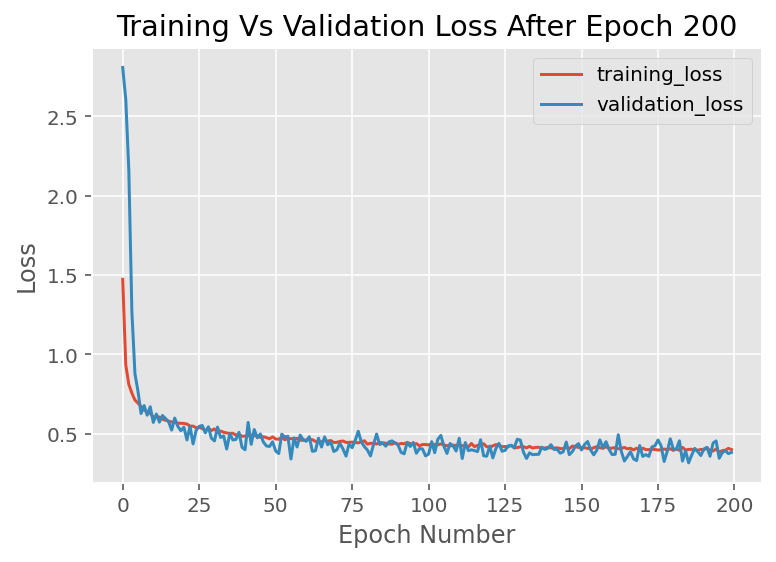

In [ ]:
history = model.fit_generator(training_data_generator,
                              validation_data = validation_data_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs = epochs,
                              callbacks = callbacks_list)

In [ ]:
checkpoints = !ls -t checkpoints | head -n1
print(checkpoints)

['-best-model-epoch:0186.hdf5']
